In [18]:
import pandas as pd
import time
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from string import punctuation
from string import capwords
import matplotlib.pyplot as plt
import pickle
from nltk.stem import PorterStemmer
ps = PorterStemmer()
from Levenshtein import distance as lev
import yaml
import re
from termcolor import colored

In [2]:
df_file = pd.read_csv('Covid-19_50000.csv') 
print(df_file.head())

         ID                                              Title  \
0  33980687  Tools and Techniques for Severe Acute Respirat...   
1  32209231  Computers and viral diseases. Preliminary bioi...   
2  32461287  Comparison of Two Commercial Molecular Tests a...   
3  32497323  Increasing host cellular receptor-angiotensin-...   
4  32462501  The Allplex 2019-nCoV (Seegene) assay: which p...   

                                            Abstract  
0  The coronavirus disease 2019 (COVID-19) pandem...  
1  This paper concerns study of the genome of the...  
2  We compared the ability of 2 commercial molecu...  
3  The ongoing outbreak of a new coronavirus (201...  
4  Several commercial assays for SARS-CoV-2 RT-PC...  


# 2. All

In [3]:
def get_wcurr_all(df_file, df_doc, all_w):
    start = time.time()
    
    for i, row in df_file.iterrows():
        p_w = {}
        con = str(row['Title']) + '\n' + str(row['Abstract'])
        pid = row['ID'] 

        if type(con) == float:
            con = str(con)
        
        # 保留'-'符號
        punc = punctuation.replace('-','')
        con_p = ''.join(w for w in con if w not in punc)

        token = word_tokenize(con_p)

        for w in token:
            # filter numbers
            # 移除 4碼年份以外的 word
            try:
                if str(int(float(w))).isnumeric() and len(w) != 4:
                    token.remove(w)
            except:
                pass

            if w in p_w.keys():
                p_w[w] += 1
            else:
                p_w[w] = 1

            if w in all_w.keys():
                all_w[w] += 1
            else:
                all_w[w] = 1

        # print(p_w)
        # print(all_w)
        df_doc.loc[len(df_doc)] = [pid, p_w]

    end = time.time()
    print('time:',end - start)
    return df_doc, all_w

In [4]:
col = ['ID', 'token_ct']
df_doc = pd.DataFrame(columns = col)
all_w = {}

df_doc, all_w = get_wcurr_all(df_file, df_doc, all_w)
# print(df_doc.head())

time: 231.8897933959961


In [5]:
df_doc.to_csv('Covid-19_token.csv', index=False)

In [6]:
sort_w = {k: v for k, v in sorted(all_w.items(), key=lambda item: item[1], reverse=True)}
a_file = open("sort_w.pkl", "wb")
pickle.dump(sort_w, a_file)
a_file.close()

# a_file = open("sort_w.pkl", "rb")
# output = pickle.load(a_file)
# print(output)
# a_file.close()

In [7]:
def print_zipf_curve(sort_w, n): 
    part_w = {k:v for k,v in list(sort_w.items())[0:n]}
    print(part_w)
    x = list(part_w.keys())
    y = list(part_w.values())
    
    plt.figure(figsize=(20, 10), dpi=80)
    plt.xticks(rotation=90)
    plt.plot(x, y, linestyle='-', marker='o', color='b', label='line with marker')
    
    for i, xy in enumerate(zip(x, y)):                                      
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
        if i == 10:
            break

{'the': 295892, 'of': 269634, 'and': 231733, 'in': 147135, 'to': 131005, 'COVID-19': 98488, 'a': 92893, 'with': 76170, 'SARS-CoV-2': 71733, 'for': 68445, 'is': 49976, 'The': 45716, 'that': 39741, 'patients': 39162, 'on': 35115, 'as': 34336, 'coronavirus': 34313, 'disease': 33020, 'by': 32292, 'are': 29031, 'was': 28193, 'infection': 27693, 'from': 26591, 'were': 26501, 'be': 24217, 'pandemic': 24158, 'respiratory': 23094, 'this': 22875, 'an': 21955, 'has': 21857, 'severe': 21504, 'have': 20083, '2019': 19642, 'we': 18698, 'acute': 18273, '2': 18145, 'or': 17234, 'syndrome': 16863, 'study': 16381, 'We': 16058, 'In': 15929, 'clinical': 15732, 'virus': 15601, 'been': 15032, 'viral': 14411, 'at': 13958, 'which': 13157, 'A': 13141, 'health': 12388, 'during': 12203, 'can': 11624, 'may': 11378, 'This': 11375, 'against': 10959, 'not': 10788, 'risk': 10788, 'treatment': 10591, 'cases': 10391, 'these': 9790, 'vaccine': 9595, 'also': 9344, 'potential': 9299, 'between': 9073, 'their': 8841, 'prote

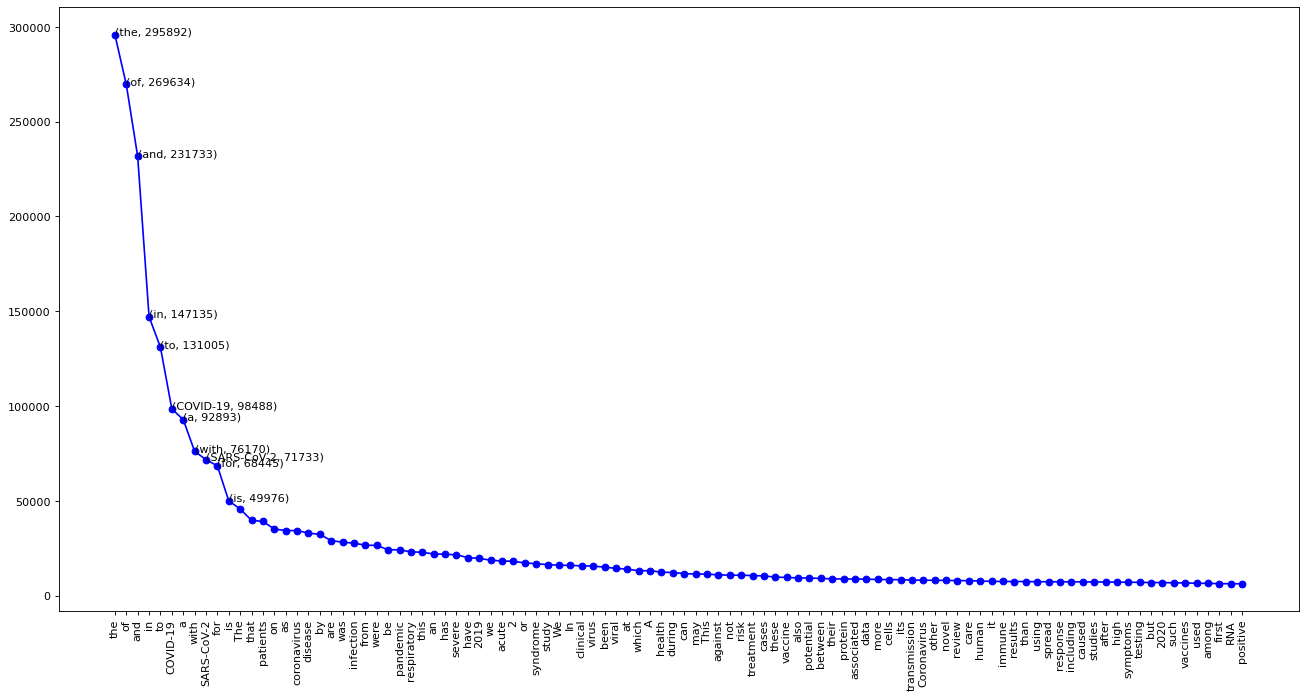

In [8]:
print_zipf_curve(sort_w, 100)

# 3. Stopped Word

In [9]:
def get_wcurr_sw(df_file, df_doc, all_w, list_my):
    start = time.time()
    for i, row in df_file.iterrows():
        p_w = {}
        con = str(row['Title']) + ' ' + str(row['Abstract'])
        pid = row['ID'] 

        if type(con) == float:
            con = str(con)

        # 保留'-'符號
        punc = punctuation.replace('-','')
        con_p = ''.join(w for w in con if w not in punc)
        token = word_tokenize(con_p)

        # 移除 4碼年份以外的 word
        # filter numbers
        for w in token:
            try:
                if str(int(float(w))).isnumeric() and len(w) != 4:
                    token.remove(w)
            except:
                pass

        # filter stopped word
        token_wsw = [w for w in token if not w in list_my]

        for w in token_wsw:

            if w in p_w.keys():
                p_w[w] += 1
            else:
                p_w[w] = 1

            if w in all_w.keys():
                all_w[w] += 1
            else:
                all_w[w] = 1

        # print(p_w)
        # print(all_w)
        df_doc.loc[len(df_doc)] = [pid, row['Title'], row['Abstract'], p_w]

    end = time.time()
    print('time:',end - start)
    return df_doc, all_w

In [10]:
col = ['ID', 'Title', 'Abstract', 'token_ct']
df_doc = pd.DataFrame(columns = col)
all_w = {}

# 增加停用字第一個字母大寫的情況
list_sw = stopwords.words('english')
list_my = []
for w in list_sw:
    # list_my.append(w.title())
    list_my.extend([w, capwords(w)])
    
df_doc, all_w = get_wcurr_sw(df_file, df_doc, all_w, list_my)
# print(df_doc.head())

time: 434.5074713230133


In [11]:
df_doc.to_csv('Covid-19_token_sw.csv', index=False)

sort_w = {k: v for k, v in sorted(all_w.items(), key=lambda item: item[1], reverse=True)}
a_file = open("sort_w_sw.pkl", "wb")
pickle.dump(sort_w, a_file)
a_file.close()

{'COVID-19': 99324, 'SARS-CoV-2': 81814, 'patients': 41684, 'coronavirus': 34366, 'disease': 33043, 'infection': 28015, 'pandemic': 24265, 'respiratory': 23125, 'severe': 21578, '2019': 19766, 'acute': 18295, 'syndrome': 16865, 'study': 16408, 'clinical': 15939, 'virus': 15671, 'viral': 14490, 'health': 12430, 'may': 11403, 'cases': 11364, 'risk': 10799, 'treatment': 10600, 'vaccine': 9655, 'also': 9362, 'potential': 9361, '2020': 9129, 'protein': 8840, 'associated': 8777, 'data': 8714, 'cells': 8490, 'transmission': 8237, 'Coronavirus': 8138, 'novel': 8050, 'review': 7949, 'care': 7910, 'human': 7768, 'immune': 7489, 'studies': 7485, 'results': 7462, 'using': 7391, 'spread': 7326, 'including': 7321, 'response': 7314, 'caused': 7276, 'high': 7124, 'symptoms': 7101, 'testing': 7012, 'vaccines': 6736, 'ACE2': 6710, 'among': 6580, 'used': 6554, 'positive': 6429, 'reported': 6388, 'first': 6350, 'RNA': 6337, 'analysis': 6246, 'antibodies': 6206, 'new': 6205, 'mortality': 6146, 'global': 60

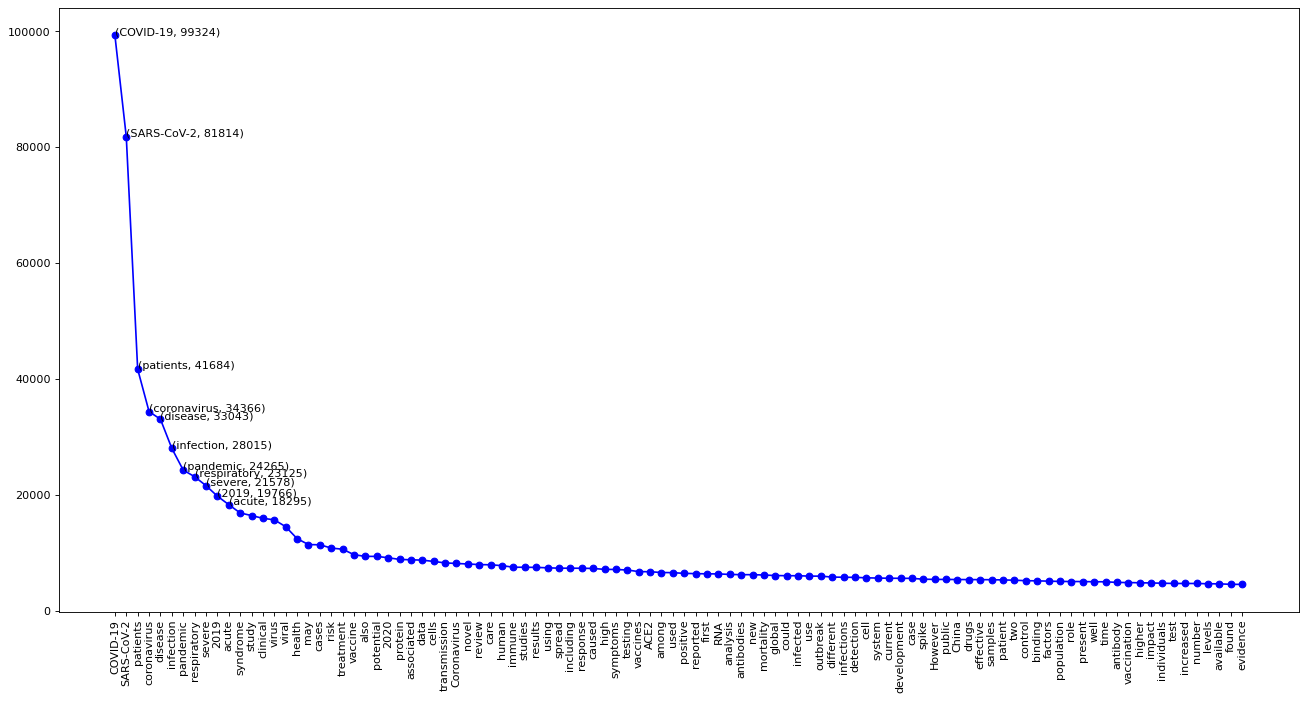

In [12]:
print_zipf_curve(sort_w, 100)

# 4. Porter's

In [16]:
def get_wcurr_sw_pt(df_file, df_doc, all_w, list_my):
    for i, row in df_file.iterrows():
        p_w = {}
        con = str(row['Title']) + ' ' + str(row['Abstract'])
        pid = row['ID'] 

        if type(con) == float:
            con = str(con)
            
        # 保留'-'符號
        punc = punctuation.replace('-','')
        con_p = ''.join(w for w in con if w not in punc)
        token = word_tokenize(con_p)
        
        # filter numbers
        # 移除 4碼年份以外的 word
        for w in token:
            try:
                if str(int(float(w))).isnumeric() and len(w) != 4:
                    token.remove(w)
            except:
                pass

        # filter stopped word
        token_wsw = [w for w in token if not w in list_my]

        for w in token_wsw:
            w_ps = ps.stem(w)

            if w_ps in p_w.keys():
                p_w[w_ps] += 1
            else:
                p_w[w_ps] = 1

            if w_ps in all_w.keys():
                all_w[w_ps] += 1
            else:
                all_w[w_ps] = 1

        # print(p_w)
        # print(all_w)
        df_doc.loc[len(df_doc)] = [pid, p_w]

    end = time.time()
    print('time:',end - start)
    return df_doc, all_w

In [17]:
col = ['ID', 'token_ct']
df_doc = pd.DataFrame(columns = col)
all_w = {}
start = time.time()

list_sw = stopwords.words('english')
list_my = []
for w in list_sw:
    # list_my.append(w.title())
    list_my.extend([w, capwords(w)])
    
df_doc, all_w = get_wcurr_sw_pt(df_file, df_doc, all_w, list_my)
# print(df_doc.head())

time: 350.73933482170105


In [19]:
df_doc.to_csv('Covid-19_token_sw_pt.csv', index=False)

sort_w = {k: v for k, v in sorted(all_w.items(), key=lambda item: item[1], reverse=True)}
a_file = open("sort_w_sw_pt.pkl", "wb")
pickle.dump(sort_w, a_file)
a_file.close()

{'covid-19': 101813, 'sars-cov-2': 83820, 'patient': 50795, 'infect': 44330, 'coronaviru': 42604, 'diseas': 40592, 'sever': 35670, 'studi': 26703, 'pandem': 26675, 'respiratori': 25833, 'vaccin': 24417, 'use': 23546, 'acut': 21052, '2019': 19767, 'clinic': 19671, 'syndrom': 19613, 'test': 19530, 'case': 18046, 'viru': 16322, 'health': 15636, 'effect': 15338, 'viral': 15325, 'cell': 14686, 'respons': 13806, 'develop': 13762, 'report': 13684, 'caus': 13677, 'protein': 13237, 'treatment': 13037, 'result': 12616, 'risk': 12609, 'may': 12572, 'associ': 12407, 'antibodi': 12088, 'immun': 12008, 'potenti': 11981, 'includ': 11551, 'detect': 11410, 'human': 10373, 'drug': 10325, 'review': 10239, 'hospit': 10165, 'system': 10067, 'increas': 9948, 'present': 9903, 'also': 9743, 'data': 9648, 'transmiss': 9648, 'emerg': 9522, 'current': 9349, 'care': 9297, 'differ': 9162, '2020': 9129, 'activ': 9093, 'novel': 8916, 'spread': 8758, 'symptom': 8616, 'identifi': 8612, 'posit': 8516, 'provid': 8370, '

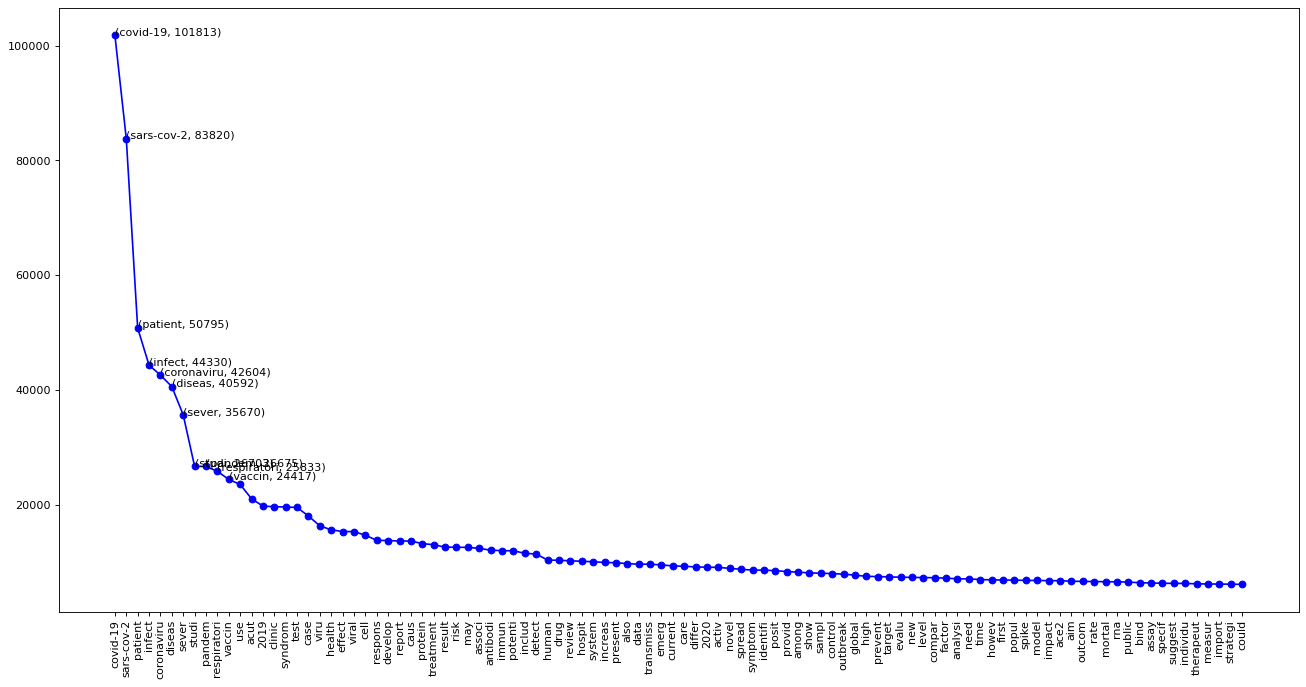

In [20]:
print_zipf_curve(sort_w, 100)

# 5. Minimum Edit Distance

In [21]:
df_file = pd.read_csv('Covid-19_token_sw.csv')

In [22]:
kw = input('Search docs according to: ')
kw = kw.strip().lower()
kw = ps.stem(kw)
print(kw)

Search docs according to: covid
covid


In [23]:
colored_text = []
cnt = 0
for i, row in df_file.iterrows():
    m_list = []
    con = str(row['Title']) + '\n' + str(row['Abstract'])
    # print(con)
    dic = row['token_ct']
    dic = yaml.load(dic, Loader = yaml.FullLoader)
    pid = row['ID']
    # print('dic:', dic)
    for k, v in dic.items():
        k_ps = ps.stem(k)
        if lev(k_ps, kw) <= 3:
            m_list.append(k)
    
    
    if len(m_list) != 0:
        print(m_list)
        print('Paper ID:', row['ID'])
        cnt += 1
        for c in re.split(r'(;|,|:|\s|[()])\s*', con):
        
            if c in m_list:
                colored_text.append(colored(c, 'grey','on_yellow'))
                
            else:
                colored_text.append(c)
                
        con = "".join(colored_text)
        colored_text = []
        print(con)        
        
    if cnt == 10:
        break

['COVID-19', 'rapid', 'devices', 'covered', 'topics', 'provide', 'advice']
Paper ID: 33980687
Tools and Techniques for Severe Acute Respiratory Syndrome Coronavirus 2 (SARS-CoV-2)/COVID-19 Detection.
The coronavirus disease 2019 (COVID-19)pandemic,caused by severe acute respiratory disease coronavirus 2 (SARS-CoV-2),has led to millions of confirmed cases and deaths worldwide. Efficient diagnostic tools are in high demand,as rapid and large-scale testing plays a pivotal role in patient management and decelerating disease spread. This paper reviews current technologies used to detect SARS-CoV-2 in clinical laboratories as well as advances made for molecular,antigen-based,and immunological point-of-care testing,including recent developments in sensor and biosensor devices. The importance of the timing and type of specimen collection is discussed,along with factors such as disease prevalence,setting,and methods. Details of the mechanisms of action of the various methodologies are presented